In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test.tsv
/kaggle/input/README
/kaggle/input/train.tsv
/kaggle/input/valid.tsv


In [2]:
!pip install transformers torch nltk pandas
!pip install gensim typing_extensions

In [3]:
import pandas as pd
import torch
import nltk
import gensim
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import os
print(os.listdir('../input'))

['test.tsv', 'README', 'train.tsv', 'valid.tsv']


## Data Visualization

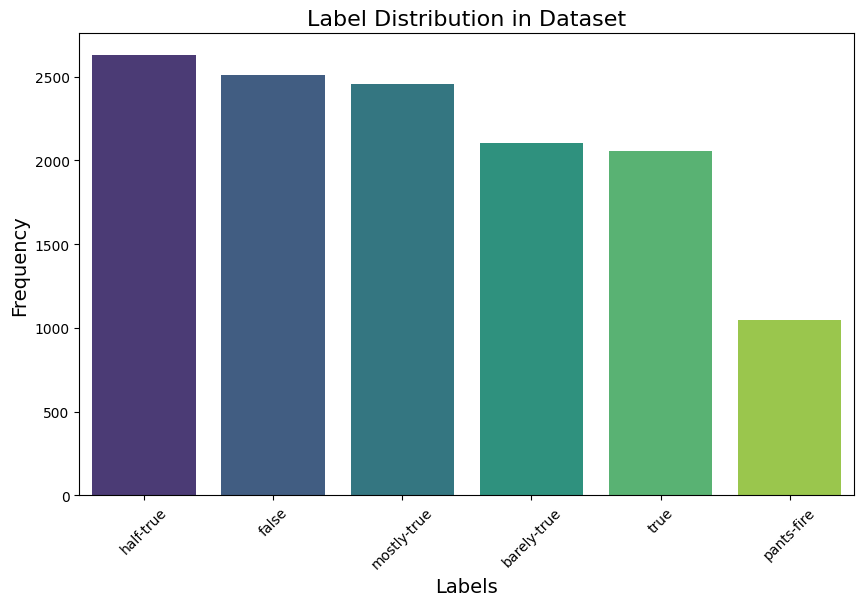

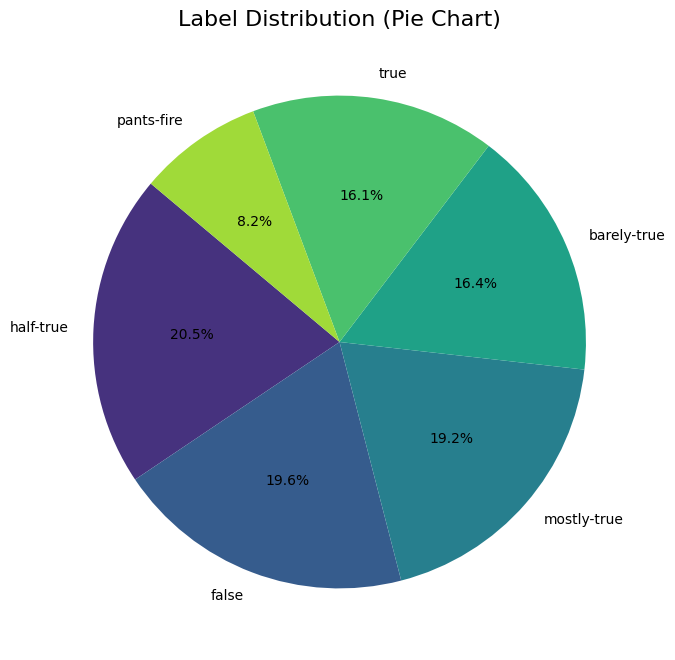

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Column names for dataset
column_names = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker Job Title', 
                'State Info', 'Party Affiliation', 'Barely True Counts', 'False Counts', 
                'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts', 
                'Context']

# File paths
test_path = '/kaggle/input/test.tsv'
train_path = '/kaggle/input/train.tsv'
val_path = '/kaggle/input/valid.tsv'

# Load the data with column names
test_dfv = pd.read_csv(test_path, sep='\t', names=column_names)
train_dfv = pd.read_csv(train_path, sep='\t', names=column_names)
val_dfv = pd.read_csv(val_path, sep='\t', names=column_names)

# Drop rows with missing values in 'Statement' or 'Label'
train_dfv = train_dfv.dropna(subset=['Statement', 'Label'])
test_dfv = test_dfv.dropna(subset=['Statement', 'Label'])
val_dfv = val_dfv.dropna(subset=['Statement', 'Label'])

# Combine the datasets for consistent preprocessing
dfv = pd.concat([test_dfv, train_dfv, val_dfv])

# Filter 'Label' and 'Statement'
dfv = dfv[['Statement', 'Label']]

# Count the occurrences of each label
label_counts = dfv['Label'].value_counts()

# Bar plot for label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Label Distribution in Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Pie chart for label distribution
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(label_counts)))
plt.title('Label Distribution (Pie Chart)', fontsize=16)
plt.show()


In [3]:
train_dfv

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


In [13]:
unique_subjects = train_dfv['Subject'].nunique()
print(f"Number of unique values in 'Subject': {unique_subjects}")

unique_subjects = train_dfv['Subject'].unique()
print(f"Unique values in 'Subject': {unique_subjects}")

Number of unique values in 'Subject': 3827
Unique values in 'Subject': ['abortion' 'energy,history,job-accomplishments' 'foreign-policy' ...
 'animals,elections' 'retirement,social-security' 'florida,foreign-policy']


## Data Preprocessing

In [10]:
# Column names for dataset
column_names = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker Job Title', 
                'State Info', 'Party Affiliation', 'Barely True Counts', 'False Counts', 
                'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts', 
                'Context']

# File paths
test_path = '/kaggle/input/test.tsv'
train_path = '/kaggle/input/train.tsv'
val_path = '/kaggle/input/valid.tsv'

# Load the data with column names
test_df = pd.read_csv(test_path, sep='\t', names=column_names)
train_df = pd.read_csv(train_path, sep='\t', names=column_names)
val_df = pd.read_csv(val_path, sep='\t', names=column_names)

# Drop rows with missing values in 'Statement' or 'Label'
train_df = train_df.dropna(subset=['Statement', 'Label'])
test_df = test_df.dropna(subset=['Statement', 'Label'])
val_df = val_df.dropna(subset=['Statement', 'Label'])

# Combine the datasets for consistent preprocessing
df = pd.concat([test_df, train_df, val_df])

# Filter 'Label' and 'Statement'
df = df[['Statement', 'Label']]

# Create label mapping
label_mapping = {
    'true': 0,
    'mostly-true': 1,
    'half-true': 2,
    'barely-true': 3,
    'false': 4,
    'pants-fire': 5
}

# Replace labels in 'Label' with the mapped numbers
df['Label'] = df['Label'].map(label_mapping)

# Split the data into train, validation, and test sets
train_val_df = df.sample(frac=0.85)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac=0.75)
val_df = train_val_df.drop(train_df.index)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save the processed sets to CSV
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)
train_df


,Statement,Label
0,Gerry Connolly and his fellow Democrats went o...,3
1,A lawyer demanded several Houston pastors hand...,0
2,It is the Department of Homeland Security's vi...,3
3,Any Floridian who has ever requested an absent...,4
4,"Palin supports ""aerial hunting of wolves and o...",0
...,...,...
8149,House Appropriations Chair David Obey's partia...,0
8150,Says that when adjusted for inflation and popu...,2
8151,"Wisconsin sold fresh water to California, help...",5
8152,Says Sen. Kay Hagan has missed half of the (Se...,1


In [11]:
# Stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
    return result

# Apply the preprocessing function to the 'Statement' column
df['clean'] = df['Statement'].apply(preprocess)

# Create a list of unique words
list_of_words = []
for i in df.clean:
    list_of_words.extend(i)

total_words = len(set(list_of_words))
print("Total unique words:", total_words)


Total unique words: 11977


In [12]:
class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        statement, label = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(int(label)) 

        tokens = self.tokenizer.encode_plus(
            statement, 
            add_special_tokens=True, 
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        tokens_tensor = tokens['input_ids'].squeeze(0)
        segments_tensor = tokens['token_type_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        return tokens_tensor, segments_tensor, attention_mask, label_tensor
    
    

    def __len__(self):
        return self.len

# Initialize the tokenizer and datasets
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:', len(trainset))
print('valset size:', len(valset))
print('testset size:', len(testset))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

trainset size: 8154
valset size: 1966
testset size: 1366


In [13]:
def collate_fn(batch):
        tokens_tensors = torch.stack([item[0] for item in batch])
        segments_tensors = torch.stack([item[1] for item in batch])
        attention_masks = torch.stack([item[2] for item in batch])
        labels = torch.stack([item[3] for item in batch])

        return tokens_tensors, segments_tensors, attention_masks, labels

BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [14]:
# Initialize the BERT model for sequence classification
NUM_LABELS = 6
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
NUM_EPOCHS = 3
model.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = data

        # Move to the device (CPU or GPU)
        tokens_tensors = tokens_tensors.to(device)
        segments_tensors = segments_tensors.to(device)
        masks_tensors = masks_tensors.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = torch.nn.functional.cross_entropy(outputs[1], labels)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs[1].data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
        train_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc=train_acc, loss=train_loss)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

In [8]:
train_df = pd.read_csv('train.tsv', sep='\t')
print(train_df.head())  # Check the first few rows to ensure correct formatting

   Label                                          Statement



0      0  Nearly half of all pregnancies in the U.S. are...



1      2  Democrats are kind of falling over each other ...



2      1  Ohio currently ranks 50th out of all states in...



3      2    Says 1,000 World War II veterans die every day.



4      0  [The state ethics commission] took absolutely ...


Accuracy: 26.72%
Precision: [0.34640523 0.29054054 0.25064599 0.25287356 0.24449339 0.34      ]
Recall: [0.24651163 0.16929134 0.33448276 0.20183486 0.41729323 0.13821138]
F1 Score: [0.28804348 0.21393035 0.28655835 0.2244898  0.30833333 0.19653179]

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.25      0.29       215
           1       0.29      0.17      0.21       254
           2       0.25      0.33      0.29       290
           3       0.25      0.20      0.22       218
           4       0.24      0.42      0.31       266
           5       0.34      0.14      0.20       123

    accuracy                           0.27      1366
   macro avg       0.29      0.25      0.25      1366
weighted avg       0.28      0.27      0.26      1366



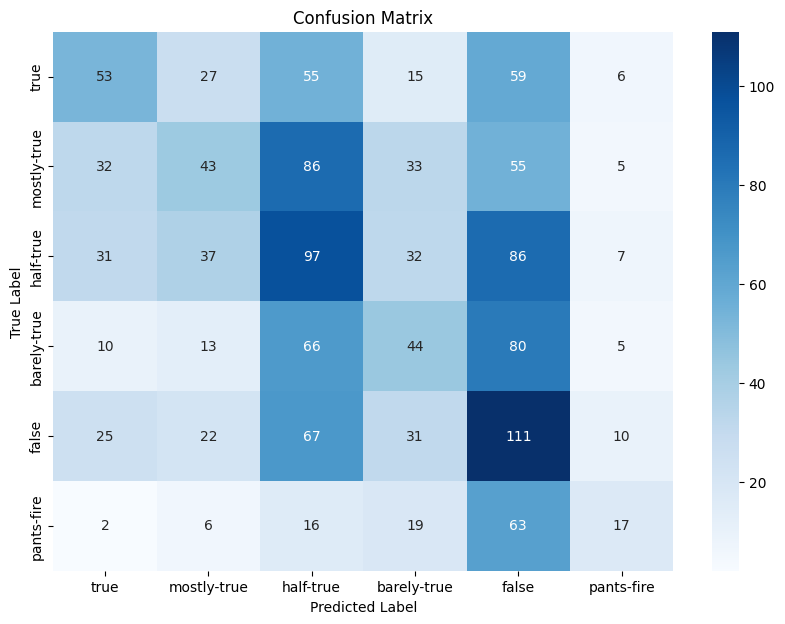

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()

# Initialize variables to track predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation (for efficiency during evaluation)
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        tokens_tensors, segments_tensors, masks_tensors, labels = data

        # Move tensors to the device (GPU or CPU)
        tokens_tensors = tokens_tensors.to(device)
        segments_tensors = segments_tensors.to(device)
        masks_tensors = masks_tensors.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors)

        # Get predicted class (highest probability)
        _, preds = torch.max(outputs.logits, 1)

        # Store the predictions and true labels
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Calculate the overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print a classification report (includes precision, recall, F1 score, support)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
